In [1]:
import numpy as np
import tensorflow as tf
from scipy import misc
from sklearn.model_selection import train_test_split
import time
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = "whitegrid", palette = "muted")
import matplotlib.gridspec as gridspec
import csv
import pandas as pd

In [2]:
def gettype(location):
    
    with open(location + '/type', 'r') as fopen:
        type_pokemon = fopen.read().split('\n')
        type_pokemon = [i.split('\t')[4:] for i in type_pokemon]
        
        for i in xrange(len(type_pokemon)):
            if len(type_pokemon[i]) == 1:
                type_pokemon[i].append('none')
        
        type_pokemon = np.array(type_pokemon)
        
        type_list = np.array(np.unique(type_pokemon[:, 0]).tolist() + np.unique(type_pokemon[:, 1]).tolist())
        
        return type_pokemon, np.unique(type_list).tolist()
        
def getpictures(location):
    
    list_folder = os.listdir(location)
    list_folder = [int(i.replace('.png', '')) for i in list_folder]
    list_folder.sort()
    list_folder = [str(i) + '.png' for i in list_folder]
    return list_folder

def generategraph(x, accuracy, lost):
    
    fig = plt.figure(figsize = (10, 5))
    
    plt.subplot(1, 2, 1)
    
    plt.plot(x, lost)
    plt.xlabel('Epoch')
    plt.ylabel('lost')
    plt.title('LOST')
    
    plt.subplot(1, 2, 2)
    
    plt.plot(x, accuracy)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('ACCURACY')
    
    fig.tight_layout()
    plt.show()

In [3]:
class Model:
    
    def __init__(self, dimension_picture, learning_rate, dimension_output):
        
        self.X = tf.placeholder(tf.float32, (None, dimension_picture, dimension_picture, 4))
        self.Y_1 = tf.placeholder(tf.float32, (None, dimension_output))
        self.Y_2 = tf.placeholder(tf.float32, (None, dimension_output))
        
        def convolutionize(x, w):
            return tf.nn.conv2d(input = x, filter = w, strides = [1, 1, 1, 1], padding = 'SAME')
        
        def pooling(wx):
            return tf.nn.max_pool(wx, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')
        
        first_W_conv = tf.Variable(tf.random_normal([5, 5, 4, 64], stddev = 0.5))
        first_b_conv = tf.Variable(tf.random_normal([64], stddev = 0.1))
        first_hidden_conv = tf.nn.relu(convolutionize(self.X, first_W_conv) + first_b_conv)
        first_hidden_pool = pooling(first_hidden_conv)
        
        second_W_conv = tf.Variable(tf.random_normal([5, 5, 64, 32], stddev = 0.5))
        second_b_conv = tf.Variable(tf.random_normal([32], stddev = 0.1))
        second_hidden_conv = tf.nn.relu(convolutionize(first_hidden_pool, second_W_conv) + second_b_conv)
        second_hidden_pool = pooling(second_hidden_conv)
        
        third_W_conv = tf.Variable(tf.random_normal([5, 5, 32, 16], stddev = 0.5))
        third_b_conv = tf.Variable(tf.random_normal([16], stddev = 0.1))
        third_hidden_conv = tf.nn.relu(convolutionize(second_hidden_pool, third_W_conv) + third_b_conv)
        third_hidden_pool = pooling(third_hidden_conv)
        
        fourth_W_conv = tf.Variable(tf.random_normal([5, 5, 16, 8], stddev = 0.5))
        fourth_b_conv = tf.Variable(tf.random_normal([8], stddev = 0.1))
        fourth_hidden_conv = tf.nn.relu(convolutionize(third_hidden_pool, fourth_W_conv) + fourth_b_conv)
        fourth_hidden_pool = pooling(fourth_hidden_conv)

        first_linear_W = tf.Variable(tf.random_normal([4 * 4 * 8, 128], stddev = 0.5))
        first_linear_b = tf.Variable(tf.random_normal([128], stddev = 0.1))
        fifth_hidden_flatted = tf.reshape(fourth_hidden_pool, [-1, 4 * 4 * 8])
        linear_layer = tf.nn.relu(tf.matmul(fifth_hidden_flatted, first_linear_W) + first_linear_b)
        
        W_1 = tf.Variable(tf.random_normal([128, dimension_output], stddev = 0.5))
        b_1 = tf.Variable(tf.random_normal([dimension_output], stddev = 0.1))
        
        W_2 = tf.Variable(tf.random_normal([128, dimension_output], stddev = 0.5))
        b_2 = tf.Variable(tf.random_normal([dimension_output], stddev = 0.1))
        
        self.y_hat_1 = tf.matmul(linear_layer, W_1) + b_1
        self.y_hat_2 = tf.matmul(linear_layer, W_2) + b_2
        
        self.cost_1 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = self.y_hat_1, labels = self.Y_1))
        self.cost_2 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = self.y_hat_2, labels = self.Y_2))
        
        self.cost = self.cost_1 + self.cost_2
        
        self.optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(self.cost)
        
        correct_prediction_1 = tf.equal(tf.argmax(self.y_hat_1, 1), tf.argmax(self.Y_1, 1))
        self.accuracy_1 = tf.reduce_mean(tf.cast(correct_prediction_1, "float"))
        
        correct_prediction_2 = tf.equal(tf.argmax(self.y_hat_2, 1), tf.argmax(self.Y_2, 1))
        self.accuracy_2 = tf.reduce_mean(tf.cast(correct_prediction_2, "float"))

In [4]:
current_location = os.getcwd()
learning_rate = 0.001
epoch = 2500
batch_size = 5
split_percentage = 0.2
test_number = 10
type_pokemon, unique_type = gettype(current_location)
pokemon_pictures = getpictures(current_location + '/pokemon')
output_dimension = len(unique_type)
picture_dimension = 64

pokemon_pictures_train, pokemon_pictures_test, pokemon_types_train, pokemon_types_test = train_test_split(pokemon_pictures, 
                                                                                                          type_pokemon, 
                                                                                                          test_size = split_percentage)


In [5]:
sess = tf.InteractiveSession()
model = Model(picture_dimension, learning_rate, output_dimension)
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver(tf.global_variables())

try:
    saver.restore(sess, current_location + "/model.ckpt")
    print "load model.."
except:
    print "start from fresh variables"

INFO:tensorflow:Restoring parameters from /home/husein/space/pokemon-type/model.ckpt
start from fresh variables


In [6]:
ACCURACY, EPOCH, LOST = [], [], []
    
for i in xrange(epoch):
    total_cost = 0
    total_accuracy = 0
    last_time = time.time()
    EPOCH.append(i)
        
    for k in xrange(0, (len(pokemon_pictures_train) // batch_size) * batch_size, batch_size):
            
        emb_data = np.zeros((batch_size, picture_dimension, picture_dimension, 4), dtype = np.float32)
        emb_data_label_1 = np.zeros((batch_size, output_dimension), dtype = np.float32)
        emb_data_label_2 = np.zeros((batch_size, output_dimension), dtype = np.float32)
            
        for x in xrange(batch_size):
                
            image = misc.imread(current_location + '/pokemon/' + pokemon_pictures_train[k + x])
            image = misc.imresize(image, (picture_dimension, picture_dimension))
            emb_data_label_1[x, unique_type.index(pokemon_types_train[k + x, 0])] = 1.0
            emb_data_label_2[x, unique_type.index(pokemon_types_train[k + x, 1])] = 1.0
                
            emb_data[x, :, :, :] = image
            
        _, loss = sess.run([model.optimizer, model.cost], feed_dict = {model.X : emb_data, model.Y_1 : emb_data_label_1, model.Y_2 : emb_data_label_2})
        accuracy_1, accuracy_2 = sess.run([model.accuracy_1, model.accuracy_2], feed_dict = {model.X : emb_data, model.Y_1 : emb_data_label_1, model.Y_2 : emb_data_label_2})
        total_cost += loss
        total_accuracy += ((accuracy_1 + accuracy_2) / 2.0) 
        
    total_accuracy /= (len(pokemon_pictures_train) // batch_size)
    total_cost /= (len(pokemon_pictures_train) // batch_size)
    ACCURACY.append(total_accuracy)
    LOST.append(total_cost)
    
    if (i + 1) % 50 == 0:
        print "epoch: " + str(i + 1) + ", loss: " + str(total_cost) + ", accuracy: " + str(total_accuracy) + ", s / batch: " + str((time.time() - last_time) / (len(pokemon_pictures_train) // batch_size))
        saver.save(sess, current_location + "/model.ckpt")

epoch: 50, loss: 2445043.2377, accuracy: 0.281967219393, s / batch: 0.00851168788847
epoch: 100, loss: 1615285.45389, accuracy: 0.326229516234, s / batch: 0.0084548035606
epoch: 150, loss: 1254219.81865, accuracy: 0.357377058048, s / batch: 0.00857311389485
epoch: 200, loss: 1034156.81378, accuracy: 0.391803289168, s / batch: 0.00849288408874
epoch: 250, loss: 878505.336578, accuracy: 0.426229519556, s / batch: 0.00853291495902
epoch: 300, loss: 758454.909324, accuracy: 0.460655747745, s / batch: 0.00846195220947
epoch: 350, loss: 663250.191214, accuracy: 0.485245914855, s / batch: 0.00849534253605
epoch: 400, loss: 583138.13864, accuracy: 0.503278703475, s / batch: 0.00849055462196
epoch: 450, loss: 517479.384766, accuracy: 0.509836076835, s / batch: 0.0084807208327
epoch: 500, loss: 460625.810403, accuracy: 0.549180341793, s / batch: 0.00846767034687
epoch: 550, loss: 411705.417162, accuracy: 0.572131162784, s / batch: 0.00850280386503
epoch: 600, loss: 368906.780289, accuracy: 0.606

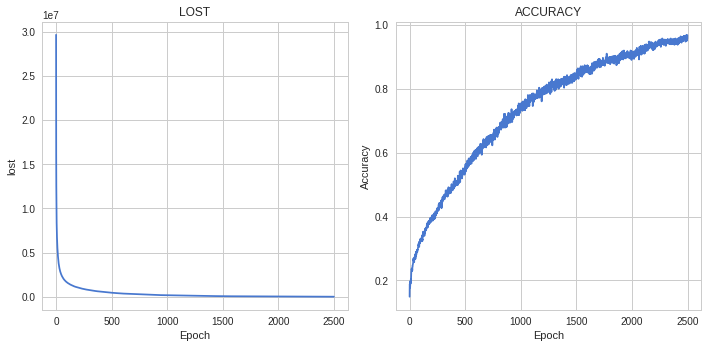

In [7]:
generategraph(EPOCH, ACCURACY, LOST)

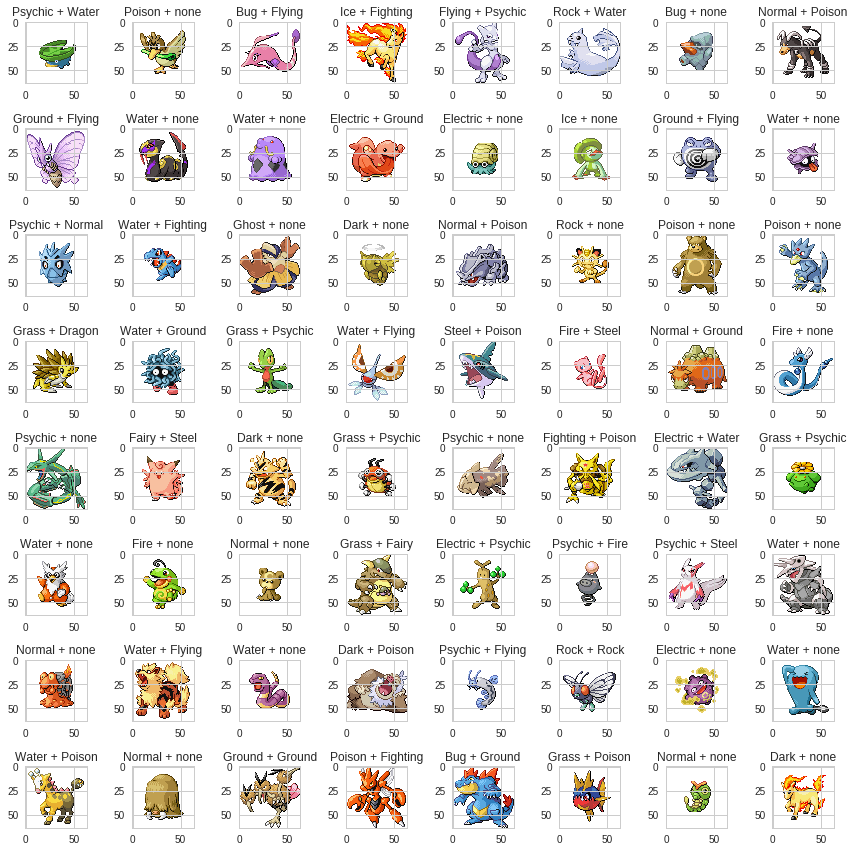

In [8]:
num_print = int(np.sqrt(len(pokemon_pictures_test)))
fig = plt.figure(figsize = (1.5 * num_print, 1.5 * num_print))
    
for k in xrange(0, num_print * num_print):
        
    plt.subplot(num_print, num_print, k + 1)
        
    emb_data = np.zeros((1, picture_dimension, picture_dimension, 4), dtype = np.float32)
            
    image = misc.imread(current_location + '/pokemon/' + pokemon_pictures_test[k])
    image = misc.imresize(image, (picture_dimension, picture_dimension))
                
    emb_data[0, :, :, :] = image
           
    y_hat_1, y_hat_2 = sess.run([model.y_hat_1, model.y_hat_2], feed_dict = {model.X : emb_data})
        
    label_1 = unique_type[np.argmax(y_hat_1[0])]
    label_2 = unique_type[np.argmax(y_hat_2[0])]
        
    plt.imshow(image)
    plt.title(label_1 + " + " + label_2)
    
fig.tight_layout()
plt.show()

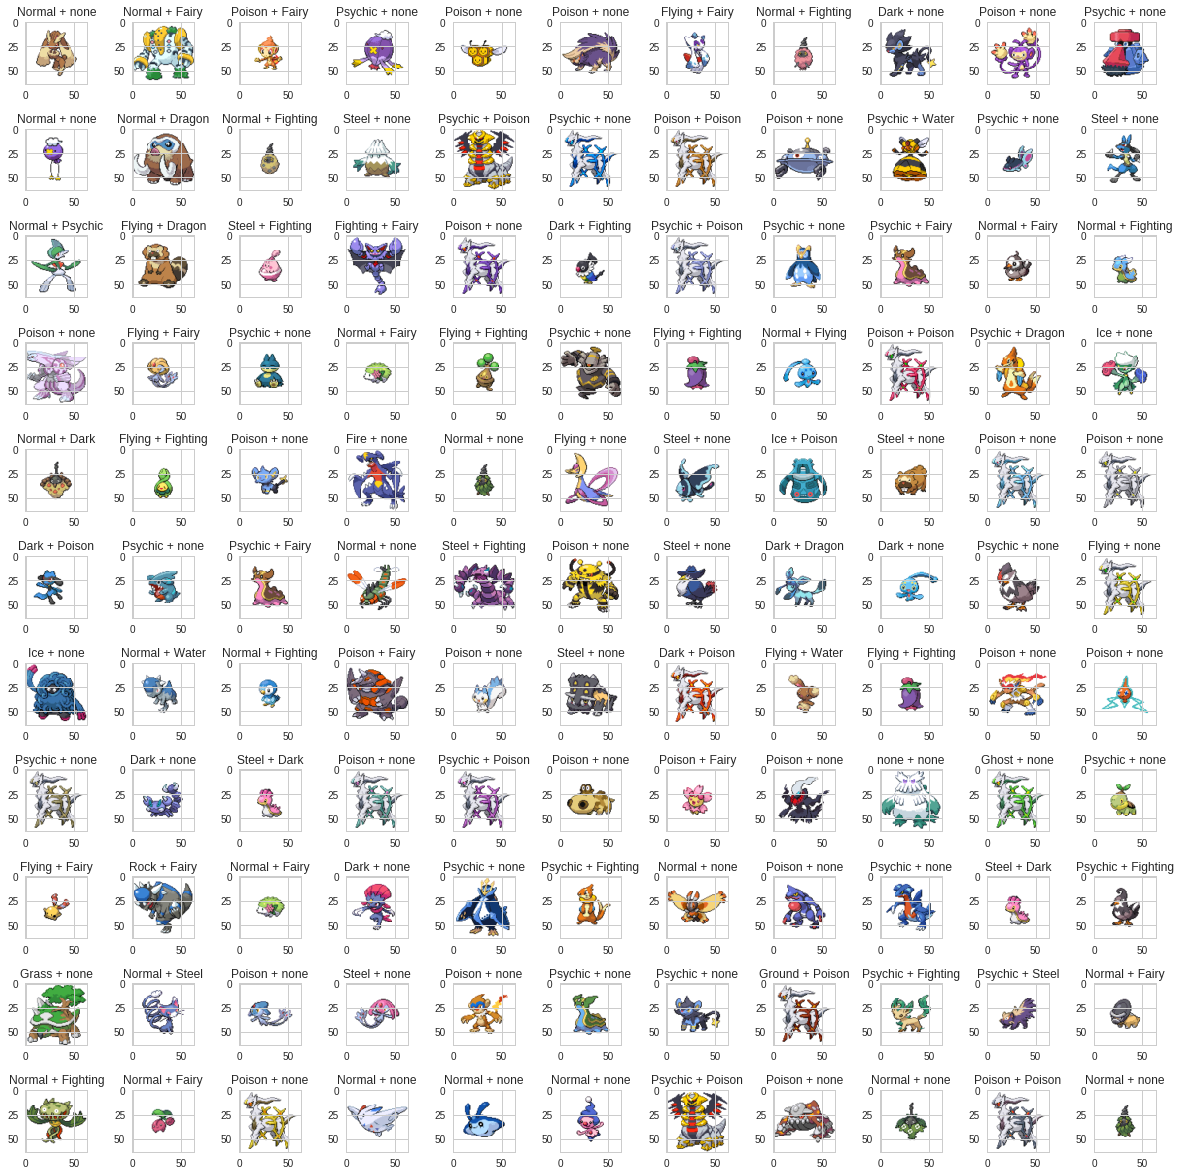

In [9]:
list_folder = os.listdir(current_location + '/diamond-pearl')
    
num_print = int(np.sqrt(len(list_folder)))
fig = plt.figure(figsize = (1.5 * num_print, 1.5 * num_print))
    
for k in xrange(0, num_print * num_print):
        
    plt.subplot(num_print, num_print, k + 1)
        
    emb_data = np.zeros((1, picture_dimension, picture_dimension, 4), dtype = np.float32)
            
    image = misc.imread(current_location + '/diamond-pearl/' + list_folder[k])
    image = misc.imresize(image, (picture_dimension, picture_dimension))
                
    emb_data[0, :, :, :] = image
           
    y_hat_1, y_hat_2 = sess.run([model.y_hat_1, model.y_hat_2], feed_dict = {model.X : emb_data})
        
    label_1 = unique_type[np.argmax(y_hat_1[0])]
    label_2 = unique_type[np.argmax(y_hat_2[0])]
        
    plt.imshow(image)
    plt.title(label_1 + " + " + label_2)
    
fig.tight_layout()
plt.show()